In [1]:
from utils.metrics import box_iou
import torch


import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import ipywidgets
from ipywidgets import interact
from tqdm import tqdm_notebook as tqdm
import os
from io import BytesIO
import cv2
import pandas as pd

In [2]:
proj = "Garbage_yolov5s_attn_with_sewage_ar0005_aug_14-02-2022"
training_data = "2022_02_14_with_sewage_ar0005_aug"

In [3]:
class report:
    def __init__(self, proj, training_data, img_w=640, img_h=480, iou=0.45, conf=0.25):
        self.training_data = training_data
        self.proj = proj
        self.img = None
        self.lbl = None
        self.pred_root = None
        self.pred = None
        self.FP = []
        self.FN = []
        self.correct = []
        self.correct_N=0
        self.img_w = img_w
        self.img_h = img_h
        self.iou_thresh = iou
        self.conf_thresh = conf
        
    def generate(self, scene):
        self.img = sorted(glob.glob('./dataset/{}/images/{}/*'.format(self.training_data, scene)))
        self.lbl = sorted(glob.glob('./dataset/{}/labels/{}/*'.format(self.training_data, scene)))
        self.pred_root = './inference/{}/{}/labels/'.format(proj,scene)
        self.pred = sorted(glob.glob(self.pred_root + '*'))
        
        print('img: {}, lbl: {}, pred: {}'.format(len(self.img), len(self.lbl), len(self.pred)))
        
        # calculate fpfns
        self.get_fpfn()
        self.plot()

    def get_fpfn_for_browse(self, i):
        FP = []
        FN = []
        correct = []
        pred_root = self.pred_root

        with open(self.lbl[i], 'r') as f:
            gt_lines = f.readlines()
            gt_box = []
            for line in gt_lines:
                cls, xc, yc, w, h = line.split(' ')

                xc, yc, h, w = float(xc), float(yc), float(h), float(w)
                xc, yc, h, w = int(self.img_w*xc), int(self.img_h*yc), int(self.img_h*h), int(self.img_w*w)

                x1, y1, x2, y2 = xc-w//2, yc-h//2, xc+w//2, yc+h//2
                gt_box.append([x1, y1, x2, y2])

        path, fname = os.path.split(self.lbl[i])
        pred_file = pred_root+fname
        pred_box = []
        if pred_file in self.pred:
            with open(pred_file, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    cls, conf, xc, yc, w, h = line.split(' ')
                    # for sewage only
                    if float(conf) <= self.conf_thresh: continue
                    xc, yc, h, w = float(xc), float(yc), float(h), float(w)
                    xc, yc, h, w = int(self.img_w*xc), int(self.img_h*yc), int(self.img_h*h), int(self.img_w*w)

                    x1, y1, x2, y2 = xc-w//2, yc-h//2, xc+w//2, yc+h//2
                    pred_box.append([x1, y1, x2, y2])

        # compare iou and find out fp and fn
        if pred_box == [] and gt_box != []:
            for gtb in gt_box:
                FN.append(gtb)
        elif gt_box == [] and pred_box != []:
            for pdb in pred_box:
                FP.append(pdb)
        else:      
            for pdb in pred_box:
                iou_fp = []
                for gtb in gt_box:
                    iou_val = box_iou(torch.tensor(pdb).view(1,4), torch.tensor(gtb).view(1,4))
                    iou_fp.append(iou_val.item())
                iou_fp = np.array(iou_fp)
                #print(all(i >= iou_thresh for i in iou_fp))
                if all(i < self.iou_thresh for i in iou_fp): # false positive
                    FP.append(pdb)
                else:
                    # means there is a pair of [gt box, pred box] satisfy the iou_thresh
                    correct.append(pdb)

            for gtb in gt_box:
                iou_fn = []
                for pdb in pred_box:
                    iou_val = box_iou(torch.tensor(pdb).view(1,4), torch.tensor(gtb).view(1,4))
                    iou_fn.append(iou_val.item())
                iou_fn = np.array(iou_fn)
                if all(i < self.iou_thresh for i in iou_fn): # false negative
                    FN.append(gtb)

        return FP, FN, correct
    
    def browse_images(self):
        n = len(self.img)

        def view_image(i):
            print(self.lbl[i])
            # read labels
            with open(self.lbl[i], 'r') as f:
                lines = f.readlines()

            # show image and draw box
            image = Image.open(self.img[i])

            plt.figure(figsize=[40,10])
            plt.subplot(1,4,1)
            plt.imshow(image)
            plt.title('Image', fontsize=20)

            plt.subplot(1,4,2)
            plt.imshow(image)

            for line in lines:
                cls, x1, y1, w, h = line.split(' ')

                x1, y1, h, w = float(x1), float(y1), float(h), float(w)
                x1, y1, h, w = int(self.img_w*x1), int(self.img_h*y1), int(self.img_h*h), int(self.img_w*w)
                print('GT box area: {}, ratio: {:.2f}%'.format(h*w, h*w/(self.img_w*self.img_h)*100))
                rect = patches.Rectangle((x1-w//2, y1-h//2), 
                                         width=w, height=h, 
                                         linewidth=1, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
            plt.title('GT Image with box: {}'.format(i), fontsize=20)
            plt.axis('off')

            plt.subplot(1,4,3)
            plt.imshow(image)

            path, fname = os.path.split(self.lbl[i])
            pred_file = self.pred_root+fname
            if pred_file in self.pred:
                with open(pred_file, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        cls, conf, x1, y1, w, h = line.split(' ')
                        if float(conf)<=self.conf_thresh:continue
                        x1, y1, h, w = float(x1), float(y1), float(h), float(w)
                        x1, y1, h, w = int(self.img_w*x1), int(self.img_h*y1), int(self.img_h*h), int(self.img_w*w)
                        print('pred box area: {}, ratio: {:.2f}%'.format(h*w, h*w/(self.img_w*self.img_h)*100))
                        rect = patches.Rectangle((x1-w//2, y1-h//2), 
                                                 width=w, height=h, 
                                                 linewidth=1, edgecolor='r', facecolor='none')
                        plt.gca().add_patch(rect)

            plt.title('Pred Image with box: {}'.format(i), fontsize=20)
            plt.axis('off')

            # get fp fn boxes
            plt.subplot(1,4,4)
            plt.imshow(np.ones((480,680,3)))
            fpbox, fnbox, correct = self.get_fpfn_for_browse(i)
            for box in fpbox:
                x1, y1, x2, y2 = box
                w, h = x2-x1, y2-y1
                rectfp = patches.Rectangle((x1, y1), 
                                         width=w, height=h,
                                         linewidth=2, edgecolor='red', facecolor='none')
                plt.gca().add_patch(rectfp)


            for box in fnbox:
                x1, y1, x2, y2 = box
                w, h = x2-x1, y2-y1
                rectfn = patches.Rectangle((x1, y1), 
                                         width=w, height=h,
                                         linewidth=2, edgecolor='blue', facecolor='none')
                plt.gca().add_patch(rectfn)

            for box in correct:
                x1, y1, x2, y2 = box
                w, h = x2-x1, y2-y1
                rectfn = patches.Rectangle((x1, y1), 
                                         width=w, height=h,
                                         linewidth=2, edgecolor='green', facecolor='none')
                plt.gca().add_patch(rectfn)


        interact(view_image, i=(0,n-1))
        
    def get_fpfn(self):

        for i, _ in enumerate(self.lbl):
            #print(self.lbl[i])
            with open(self.lbl[i], 'r') as f:
                gt_lines = f.readlines()
                gt_box = []
                for line in gt_lines:
                    cls, xc, yc, w, h = line.split(' ')

                    xc, yc, h, w = float(xc), float(yc), float(h), float(w)
                    xc, yc, h, w = int(self.img_w*xc), int(self.img_h*yc), int(self.img_h*h), int(self.img_w*w)

                    x1, y1, x2, y2 = xc-w//2, yc-h//2, xc+w//2, yc+h//2
                    gt_box.append([x1, y1, x2, y2])

            path, fname = os.path.split(self.lbl[i])
            pred_file = self.pred_root+fname
            pred_box = []
            if pred_file in self.pred:
                with open(pred_file, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        cls, conf, xc, yc, w, h = line.split(' ')
                        if float(conf)<=self.conf_thresh:continue
                        xc, yc, h, w = float(xc), float(yc), float(h), float(w)
                        xc, yc, h, w = int(self.img_w*xc), int(self.img_h*yc), int(self.img_h*h), int(self.img_w*w)

                        x1, y1, x2, y2 = xc-w//2, yc-h//2, xc+w//2, yc+h//2
                        pred_box.append([x1, y1, x2, y2])

            # compare iou and find out fp and fn
            if pred_box == [] and gt_box != []:
                for gtb in gt_box:
                    self.FN.append(gtb)
                    x1, y1, x2, y2 = gtb
                    #if (x2-x1)>50 or (y2-y1)>h > 50:
                        #print(i, w, h)
                    #print(i)
            elif gt_box == [] and pred_box == []:
                self.correct_N += 1
            elif gt_box == [] and pred_box != []:
                for pdb in pred_box:
                    self.FP.append(pdb)
                    #print(i)
            else:      
                for pdb in pred_box:
                    iou_fp = []
                    for gtb in gt_box:
                        iou_val = box_iou(torch.tensor(pdb).view(1,4), torch.tensor(gtb).view(1,4))
                        iou_fp.append(iou_val.item())
                    iou_fp = np.array(iou_fp)
                    # print(all(i < iou_thresh for i in iou_fp))
                    if all(i < self.iou_thresh for i in iou_fp): # false positive
                        self.FP.append(pdb)
                        #print(i)
                    else:
                        # means there is a gt box satisfy the iou_thresh
                        self.correct.append(pdb)

                for gtb in gt_box:
                    iou_fn = []
                    for pdb in pred_box:
                        iou_val = box_iou(torch.tensor(pdb).view(1,4), torch.tensor(gtb).view(1,4))
                        iou_fn.append(iou_val.item())
                    iou_fn = np.array(iou_fn)
                    if all(i < self.iou_thresh for i in iou_fn): # false negative
                        x1, y1, x2, y2 = gtb
                        #if (x2-x1)>50 or (y2-y1)>h > 50:
                        #    print(i, w, h)
                        self.FN.append(gtb)
                        #print(i)
        
        
    def plot(self):
        tp = len(self.correct)
        fp = len(self.FP)
        fn = len(self.FN)
        tn = self.correct_N

        print(tp, fp, fn, tn)
        print('precision:{:.3f}, recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

        x = ["papershred_GT", "BG_GT"]
        y = ["papershred_Pred", "BG_Pred"]

        result = np.array([tp, fp, fn, np.NaN]).reshape(2,2)


        fig, ax = plt.subplots()
        plt.imshow(result)

        # Show all ticks and label them with the respective list entries
        plt.xticks(np.arange(len(x)), labels=x)
        plt.yticks(np.arange(len(y)), labels=y)

        for i in range(len(x)):
            for j in range(len(y)):
                if i==len(x)-1 and j== len(y)-1:continue
                text = ax.text(j, i, result[i, j],
                               ha="center", va="center", color="r", fontsize=16)

        # PNC plots
        plt.figure(figsize=[15,20])
        plt.subplot(1,3,1)
        plt.imshow(np.ones((480,680,3)))
        plt.yticks([0, 26, 97, 480], ['0-6m','26-4m', '97-2m', '480-0.25m'])

        fpy = []
        for box in self.FP:
            x1, y1, x2, y2 = box
            w, h = x2-x1, y2-y1
            #if w>50 or h>50: continue
            rect = patches.Rectangle((x1, y1), 
                                     width=w, height=h,
                                     linewidth=1, edgecolor='red', facecolor='none')
            fpy.append(y1)
            plt.gca().add_patch(rect)
        plt.title('FP boxes spatial distribution')

        plt.subplot(1,3,2)
        plt.imshow(np.ones((480,680,3)))
        plt.yticks([0, 26, 97, 480], ['0-6m','26-4m', '97-2m', '480-0.25m'])
        fny = []
        for box in self.FN:
            x1, y1, x2, y2 = box
            w, h = x2-x1, y2-y1
            #if w>80 or h>80: continue
            #if y2 > 250 and np.random.rand() > 0.15 and 250<x1<400:continue
            #if y2 > 200 and np.random.rand() > 0.25:continue
            rect = patches.Rectangle((x1, y1), 
                                     width=w, height=h,
                                     linewidth=1, edgecolor='blue', facecolor='none')
            fny.append(y1)
            plt.gca().add_patch(rect)
        plt.title('FN boxes spatial distribution')

        plt.subplot(1,3,3)
        plt.imshow(np.ones((480,680,3)))
        plt.yticks([0, 26, 97, 480], ['0-6m','26-4m', '97-2m', '480-0.25m'])
        cy = []
        for box in self.correct:
            x1, y1, x2, y2 = box
            w, h = x2-x1, y2-y1
            #if y2 > 250 and np.random.rand() > 0.15 and 250<x1<400:continue
            #if y2 > 200 and np.random.rand() > 0.25:continue
            rect = patches.Rectangle((x1, y1), 
                                     width=w, height=h,
                                     linewidth=1, edgecolor='green', facecolor='none')
            cy.append(y1)
            plt.gca().add_patch(rect)
        plt.title('correct boxes spatial distribution')

In [4]:
rp = report(proj, training_data)

img: 10894, lbl: 10894, pred: 5555
0 8530 10055 5173
precision:0.000, recall:0.000


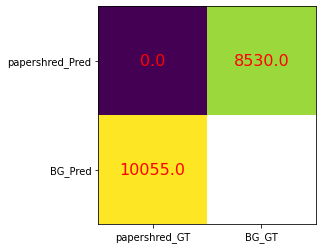

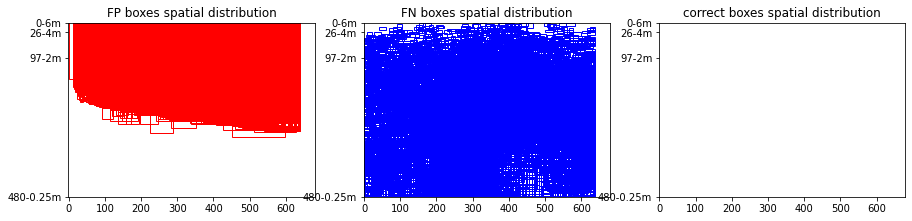

In [5]:
rp.generate(scene ='test')

In [6]:
rp.browse_images()

interactive(children=(IntSlider(value=5446, description='i', max=10893), Output()), _dom_classes=('widget-inte…